#### Import Modules

In [1]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
import colabtools

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [2]:
# more common libraries for retrieving data
import librosa
import librosa.display
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import audioread
import json
import os
import itertools
from PIL import Image
import cv2

#### Preprocessing Functions

In [12]:
# return 3 self similarity matrices
def get_3ssm(audio_path):
    
    print("3ssm")
    
    # load audio into np array
    y,sr = librosa.load(audio_path)
    audiolen = round(librosa.get_duration(y=y, sr=sr))

    # compute mfcc features and ssm
    hop_length = 1024
    mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=hop_length)
    ssm_mfcc = librosa.segment.recurrence_matrix(mfcc, metric='cosine', mode='affinity')
    print(ssm_mfcc.shape)
    ssm_mfcc = np.resize(ssm_mfcc, (audiolen, audiolen))
    print(ssm_mfcc.shape)
    
    #compute chroma features and ssm
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length = hop_length)
    ssm_chroma = librosa.segment.recurrence_matrix(chroma, metric='cosine', mode='affinity')
    ssm_chroma = np.resize(ssm_chroma, (audiolen, audiolen))

    #compute mel-spec features and ssm
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, hop_length = hop_length)
    ssm_melspec = librosa.segment.recurrence_matrix(mel_spec, metric ='cosine', mode='affinity')
    ssm_melspec = np.resize(ssm_melspec, (audiolen, audiolen))

    return ssm_mfcc, ssm_chroma, ssm_melspec

# compress SSMs into png format
def ssm_to_png(mfcc, chroma, melspec, out_path):
    
    rgbArray = np.zeros((mfcc.shape[0],mfcc.shape[1],3), 'uint8')
    
    rgbArray[..., 0] = (mfcc/mfcc.max())*256
    rgbArray[..., 1] = (chroma/chroma.max())*256
    rgbArray[..., 2] = (melspec/melspec.max())*256
    
    
    print(rgbArray.shape)
    
    img = Image.fromarray(rgbArray)
    img.save(out_path)
    
# return bounding box of chorus, verse, and intro labels of jams dataset    
def get_bbox(anno_path):
    
    # open file
    with open(anno_path) as a:
        data = json.load(a)    

    # check through all annotations and count segment labels    
    obj_list = []
    
    for annotation in data['annotations']:
        
        chorus = []
        verse = []
        intro = []
        segments = []

        for segment in annotation['data']:
            if segment['value'] == "chorus":
                chorus.append([segment['time'], segment["duration"]])
            elif segment['value'] == "verse":
                verse.append([segment['time'], segment["duration"]])
            elif segment['value'] == "intro":
                intro.append([segment['time'], segment["duration"]])

        segments.append(chorus)
        segments.append(verse)
        segments.append(intro)

        colors = ['r','g','b']
        c = 0
        for seglabels in segments:
            segcombos = itertools.product(seglabels, repeat=2)
            
            # get the segment combination bounding boxes
            for combo in segcombos:
                
                rect =  patches.Rectangle((combo[0][0], combo[1][0]), combo[0][1], combo[1][1], linewidth=1,edgecolor = colors[c], facecolor = 'none')
                bound = rect.get_bbox()
             
                xcount = int(round((bound.x1-bound.x0)/0.5))
                ycount = int(round((bound.y1-bound.y0)/0.5))
                px = np.linspace(bound.x0, bound.x1, xcount)
                py = np.linspace(bound.y0, bound.y1, ycount)

                poly1 = [(bound.x0, y) for y in py]
                poly2 = [(bound.x1, y) for y in py]
                poly3 = [(x, bound.y0) for x in px]
                poly4 = [(x, bound.y1) for x in px]

                newpoly = np.concatenate((poly1, poly2, poly3, poly4))
                newpoly = np.array(list(np.hstack(newpoly)))
                newpoly = (np.transpose(newpoly.reshape((np.shape(newpoly)[0],1)))).tolist()
                
                obj = {
                    "bbox": [bound.x0, bound.y0, bound.x1, bound.y1],
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "segmentation": newpoly,
                    "category_id": c,
                }
                obj_list.append(obj)
                
            c = c+1
    return obj_list

In [4]:
# return data in detectron dataset format
def get_audio_dicts(ds_dir):
    
    annos = '/home/shared/cuzokwe/datasets/SALAMI/references/'
    audio = ds_dir + 'audio'
    
    dataset_annos = []
    # Parse through available audio tags
    for file in os.listdir(audio):
        anno = annos +'SALAMI_' + file.split(".")[0] + '.jams'
        print('audio file: ' + file.split(".")[0])
        if os.path.exists(anno):
            record = {}
            
            img = ds_dir + "/images/"+ file.split(".")[0] + '.png'
            if os.path.exists(img):
                record["file_name"] = img
            else:
                mfcc, chroma, melspec = get_3ssm(audio + '/' + file.split(".")[0] + '.wav')
                ssm_to_png(mfcc, chroma, melspec, img)
                
                
                record["file_name"] = img                
            
            record["image_id"] = int(file.split(".")[0])
            
            img = cv2.imread(img)
            dimensions = img.shape
            record["height"] = dimensions[0]
            record["width"] = dimensions[1]
        
            
            objs = get_bbox(anno)
            record["annotations"] = objs
            
        
        dataset_annos.append(record)
    return dataset_annos     

#### Register Catalog and Visualize Data

In [5]:
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog
ds_train = '/home/shared/cuzokwe/train/'
ds_val = '/home/shared/cuzokwe/val/'

In [6]:
# register training set data and metadata
DatasetCatalog.register("salami_2020_img_train", lambda ds_train=ds_train: get_audio_dicts(ds_train))
MetadataCatalog.get("salami_2020_img_train").thing_classes = ["chorus", "verse","intro"]

In [7]:
# register validation set data and metadata
DatasetCatalog.register("salami_2020_img_val", lambda ds_val=ds_val: get_audio_dicts(ds_val))
MetadataCatalog.get("salami_2020_img_val").thing_classes = ["chorus", "verse","intro"]

In [8]:
# unregister dataset
#DatasetCatalog.clear()

In [9]:
# show registered datasets
DatasetCatalog.list()

['coco_2014_train',
 'coco_2014_val',
 'coco_2014_minival',
 'coco_2014_minival_100',
 'coco_2014_valminusminival',
 'coco_2017_train',
 'coco_2017_val',
 'coco_2017_test',
 'coco_2017_test-dev',
 'coco_2017_val_100',
 'keypoints_coco_2014_train',
 'keypoints_coco_2014_val',
 'keypoints_coco_2014_minival',
 'keypoints_coco_2014_valminusminival',
 'keypoints_coco_2014_minival_100',
 'keypoints_coco_2017_train',
 'keypoints_coco_2017_val',
 'keypoints_coco_2017_val_100',
 'coco_2017_train_panoptic_separated',
 'coco_2017_train_panoptic_stuffonly',
 'coco_2017_val_panoptic_separated',
 'coco_2017_val_panoptic_stuffonly',
 'coco_2017_val_100_panoptic_separated',
 'coco_2017_val_100_panoptic_stuffonly',
 'lvis_v0.5_train',
 'lvis_v0.5_val',
 'lvis_v0.5_val_rand_100',
 'lvis_v0.5_test',
 'lvis_v0.5_train_cocofied',
 'lvis_v0.5_val_cocofied',
 'cityscapes_fine_instance_seg_train',
 'cityscapes_fine_sem_seg_train',
 'cityscapes_fine_instance_seg_val',
 'cityscapes_fine_sem_seg_val',
 'cityscap

In [13]:
dataset_dicts_train = get_audio_dicts(ds_train)

audio file: 355
audio file: 343
audio file: 411
audio file: 930
audio file: 618
audio file: 639
audio file: 636
audio file: 268
audio file: 67
audio file: 495
audio file: 79
audio file: 236
audio file: 651
audio file: 82
audio file: 770
audio file: 332
audio file: 510
audio file: 700
audio file: 675
audio file: 757
audio file: 936
audio file: 154
audio file: 399
audio file: 468
audio file: 536
audio file: 440
audio file: 842
audio file: 658
audio file: 880
audio file: 32
audio file: 107
audio file: 186
audio file: 899
audio file: 720
audio file: 844
audio file: 596
audio file: 364
audio file: 498
audio file: 725
audio file: 482
audio file: 458
audio file: 146
audio file: 599
audio file: 728
audio file: 315
audio file: 397
audio file: 696
audio file: 128
audio file: 634
audio file: 506
audio file: 772
audio file: 218
audio file: 591
audio file: 855
audio file: 503
audio file: 723
audio file: 952
audio file: 831
audio file: 659
audio file: 549
audio file: 48
audio file: 707
audio file: 2

(230, 230, 3)
/home/shared/cuzokwe/train//images/655.png


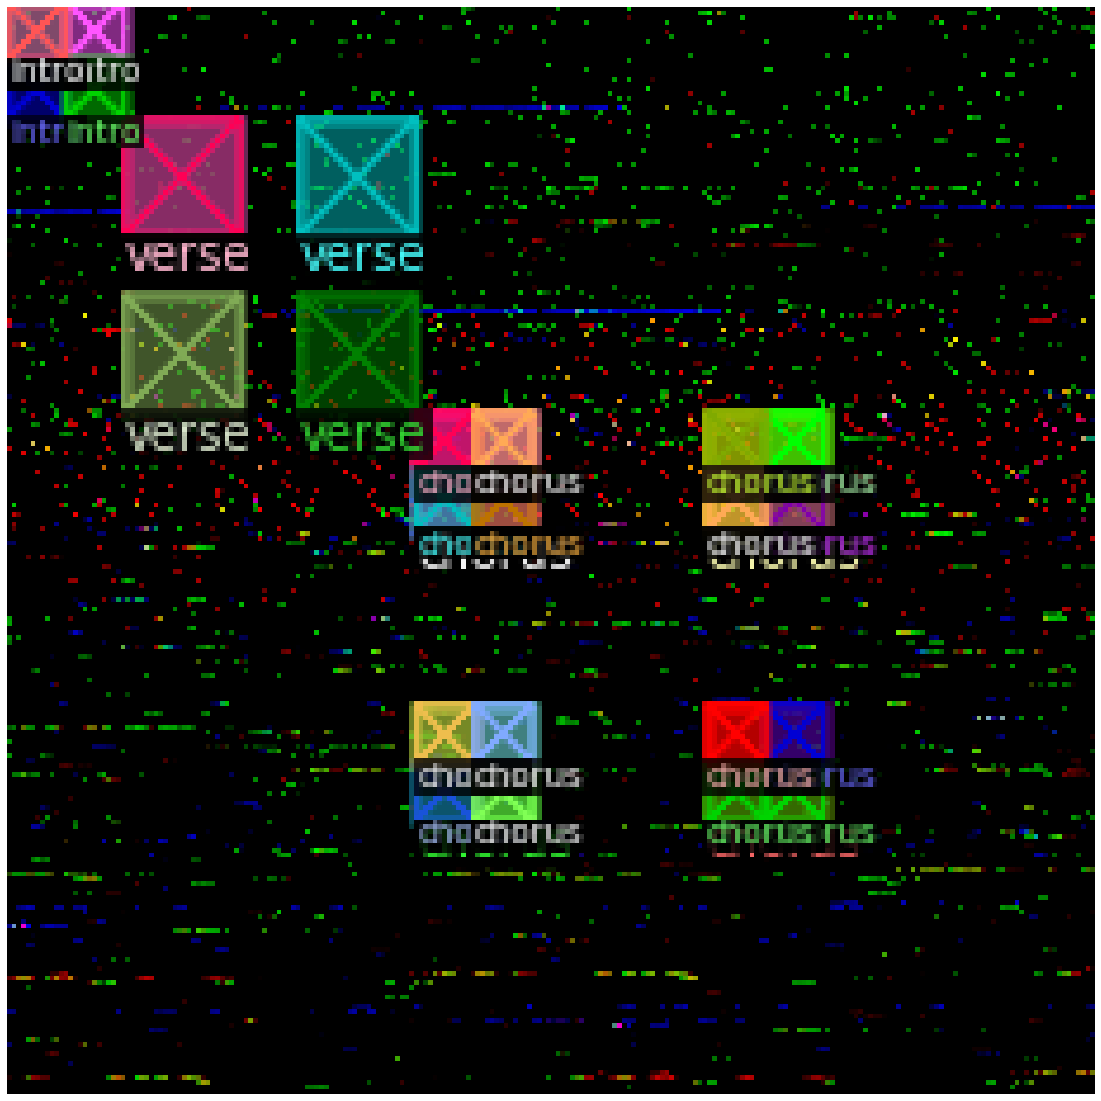

(658, 658, 3)
/home/shared/cuzokwe/train//images/276.png


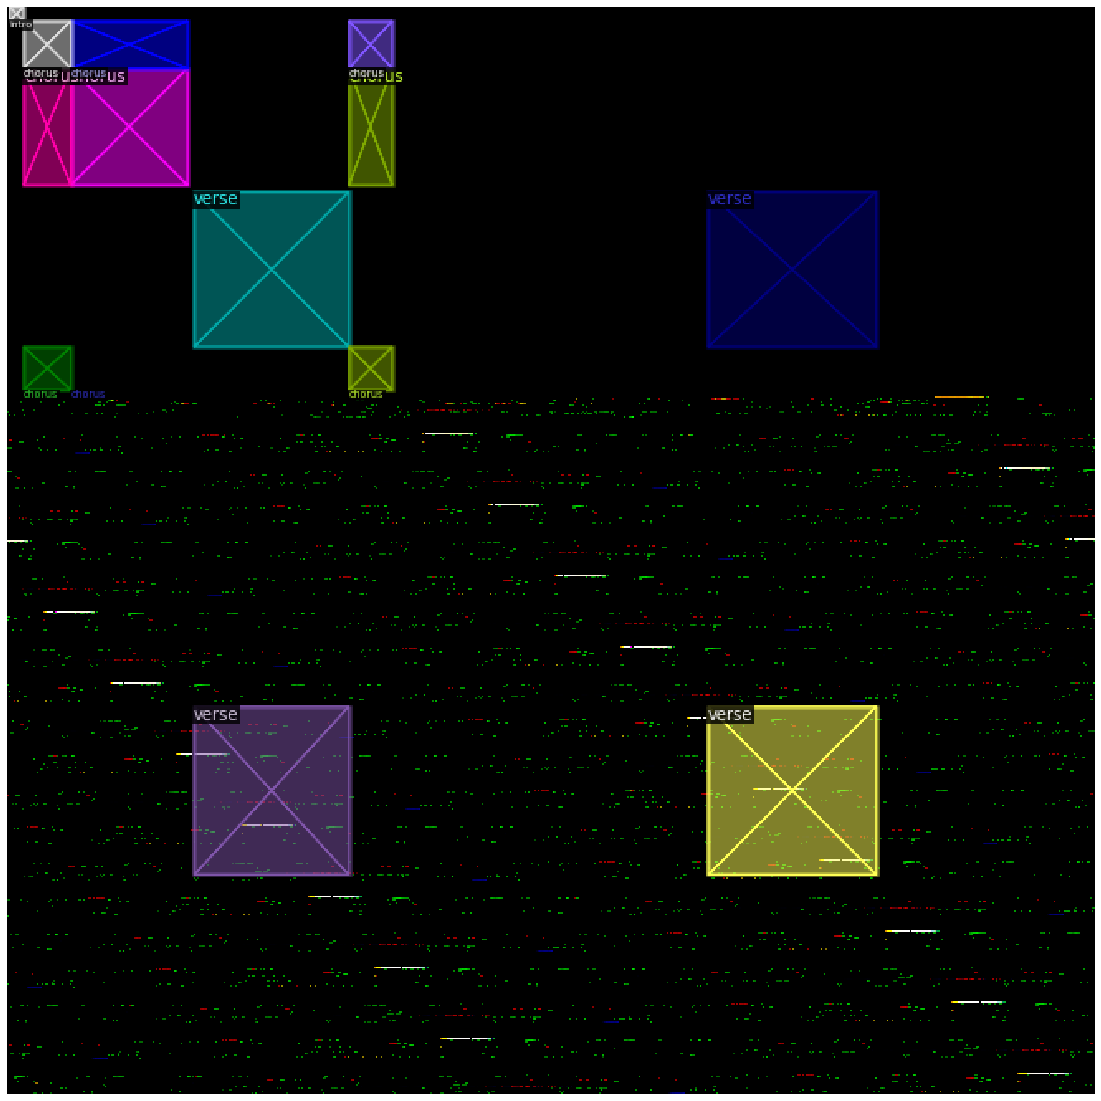

(235, 235, 3)
/home/shared/cuzokwe/train//images/894.png


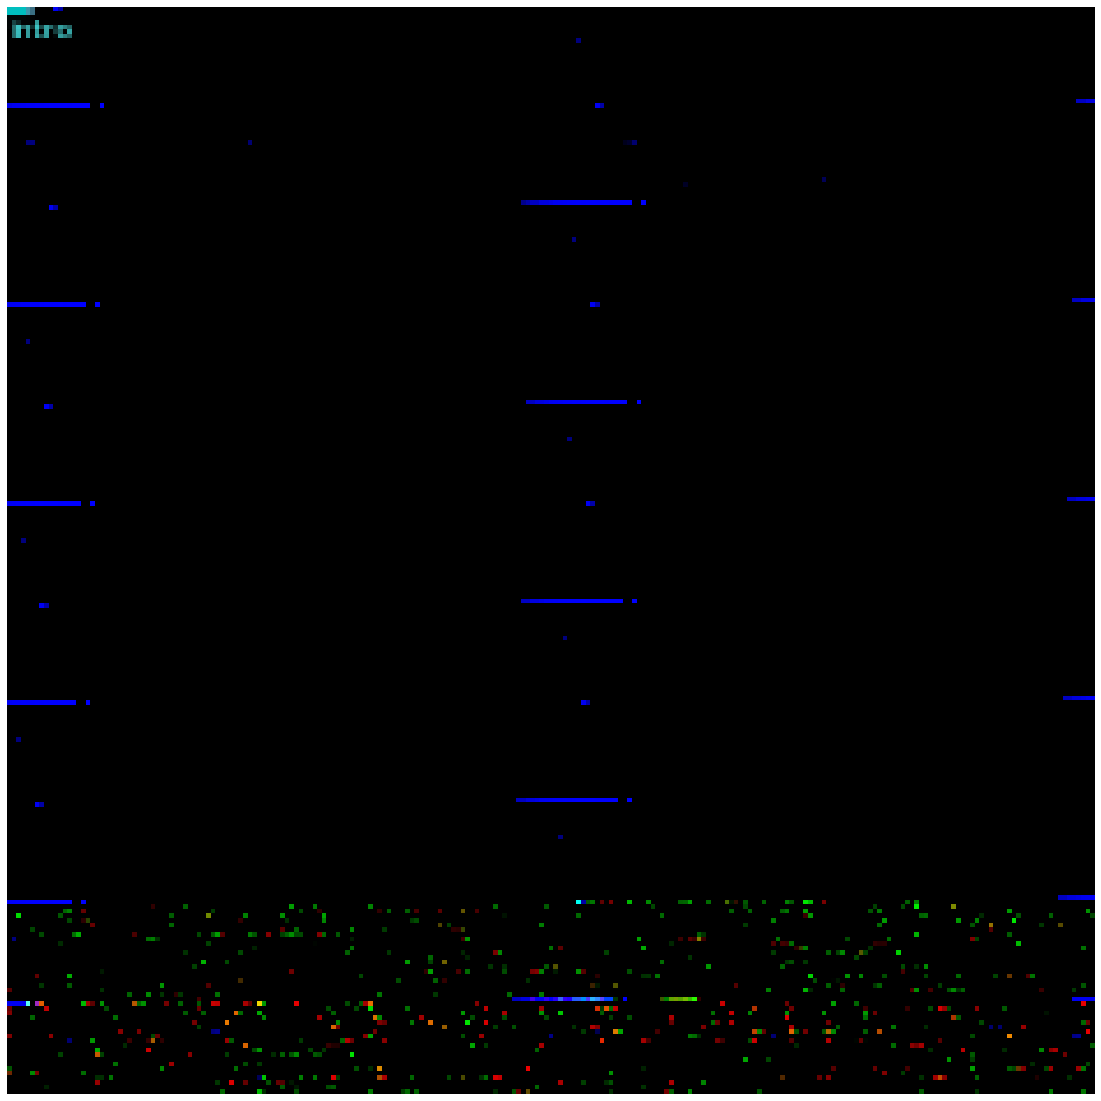

In [23]:
audio_metadata = MetadataCatalog.get("salami_2020_img_train")
for d in random.sample(dataset_dicts_train, 3):
    img = cv2.imread(d["file_name"])
    print(img.shape)
    print(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=audio_metadata, scale=1)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=(20,20))
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()


### Train the Model

In [18]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("salami_2020_img_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[04/10 12:06:59 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

audio file: 355
audio file: 343
audio file: 411
audio file: 930
audio file: 618
audio file: 639
audio file: 636
audio file: 268
audio file: 67
audio file: 495
audio file: 79
audio file: 236
audio file: 651
audio file: 82
audio file: 770
audio file: 332
audio file: 510
audio file: 700
audio file: 675
audio file: 757
audio file: 936
audio file: 154
audio file: 399
audio file: 468
audio file: 536
audio file: 440
audio file: 842
audio file: 658
audio file: 880
audio file: 32
audio file: 107
audio file: 186
audio file: 899
audio file: 720
audio file: 844
audio file: 596
audio file: 364
audio file: 498
audio file: 725
audio file: 482
audio file: 458
audio file: 146
audio file: 599
audio file: 728
audio file: 315
audio file: 397
audio file: 696
audio file: 128
audio file: 634
audio file: 506
audio file: 772
audio file: 218
audio file: 591
audio file: 855
audio file: 503
audio file: 723
audio file: 952
audio file: 831
audio file: 659
audio file: 549
audio file: 48
audio file: 707
audio file: 2

[04/10 12:07:11 d2.data.common]: Serializing 418 elements to byte tensors and concatenating them all ...
[04/10 12:07:11 d2.data.common]: Serialized dataset takes 47.88 MiB
[04/10 12:07:11 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/10 12:07:11 d2.data.build]: Using training sampler TrainingSampler


'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (4, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (4,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (12, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (12,) in the model! Skipped.
'roi_heads.mask_head.predictor.weight' has shape (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) in the model! Skipped.
'roi_heads.mask_head.predictor.bias' has shape (80,) in the checkpoint but (3,) in the model! Skipped.


[04/10 12:07:13 d2.engine.train_loop]: Starting training from iteration 0
[04/10 12:07:18 d2.utils.events]:  eta: 0:01:07  iter: 19  total_loss: 6.013  loss_cls: 1.610  loss_box_reg: 0.048  loss_mask: 0.691  loss_rpn_cls: 3.224  loss_rpn_loc: 0.250  time: 0.2353  data_time: 0.0165  lr: 0.000005  max_mem: 1862M
[04/10 12:07:23 d2.utils.events]:  eta: 0:01:02  iter: 39  total_loss: 4.289  loss_cls: 1.388  loss_box_reg: 0.082  loss_mask: 0.686  loss_rpn_cls: 1.877  loss_rpn_loc: 0.257  time: 0.2341  data_time: 0.0082  lr: 0.000010  max_mem: 2297M
[04/10 12:07:28 d2.utils.events]:  eta: 0:00:57  iter: 59  total_loss: 3.320  loss_cls: 1.113  loss_box_reg: 0.095  loss_mask: 0.679  loss_rpn_cls: 0.973  loss_rpn_loc: 0.254  time: 0.2343  data_time: 0.0085  lr: 0.000015  max_mem: 2297M
[04/10 12:07:32 d2.utils.events]:  eta: 0:00:52  iter: 79  total_loss: 2.542  loss_cls: 0.877  loss_box_reg: 0.158  loss_mask: 0.666  loss_rpn_cls: 0.561  loss_rpn_loc: 0.177  time: 0.2358  data_time: 0.0087  lr:

In [ ]:
# Look at training curves in tensorboard:

import tensorflow as tf
import datetime, os

%load_ext tensorboard
%tensorboard --logdir {logs_base_dir}  --host moog.ece.drexel.edu

In [19]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("salami_2020_img_val", )
predictor = DefaultPredictor(cfg)
print(cfg.OUTPUT_DIR)

./output


audio file: 847
audio file: 346
audio file: 704
audio file: 110
audio file: 124
audio file: 365
audio file: 620
audio file: 299
audio file: 731
audio file: 320
audio file: 800
audio file: 508
audio file: 890
audio file: 396
audio file: 427
audio file: 654
audio file: 1621
audio file: 612
audio file: 338
audio file: 173
audio file: 1648
audio file: 674
audio file: 714
audio file: 155
audio file: 573
audio file: 837
audio file: 630
audio file: 228
audio file: 859
audio file: 499
audio file: 565
audio file: 763
audio file: 2
audio file: 53
audio file: 283
audio file: 39
audio file: 1613
audio file: 747
audio file: 581
audio file: 139
audio file: 640
audio file: 773
audio file: 467
audio file: 722
audio file: 901
audio file: 663
audio file: 944
audio file: 691
audio file: 451
audio file: 517
audio file: 310
audio file: 245
audio file: 813
audio file: 13
audio file: 592
audio file: 376
audio file: 919
audio file: 405
audio file: 213
audio file: 328
audio file: 386
audio file: 480
audio file

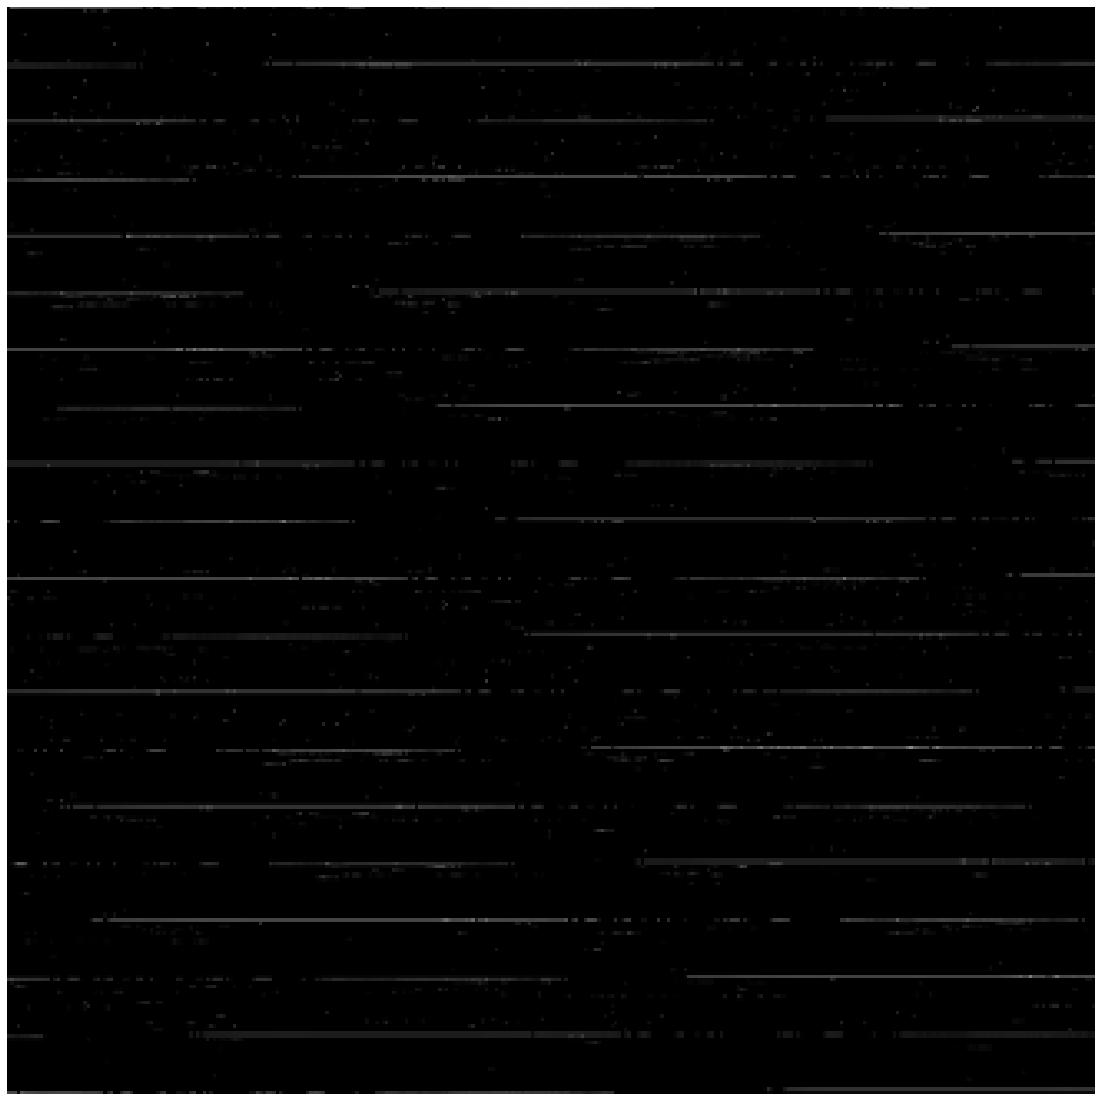

Instances(num_instances=0, image_height=355, image_width=355, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 355, 355), dtype=torch.uint8)])


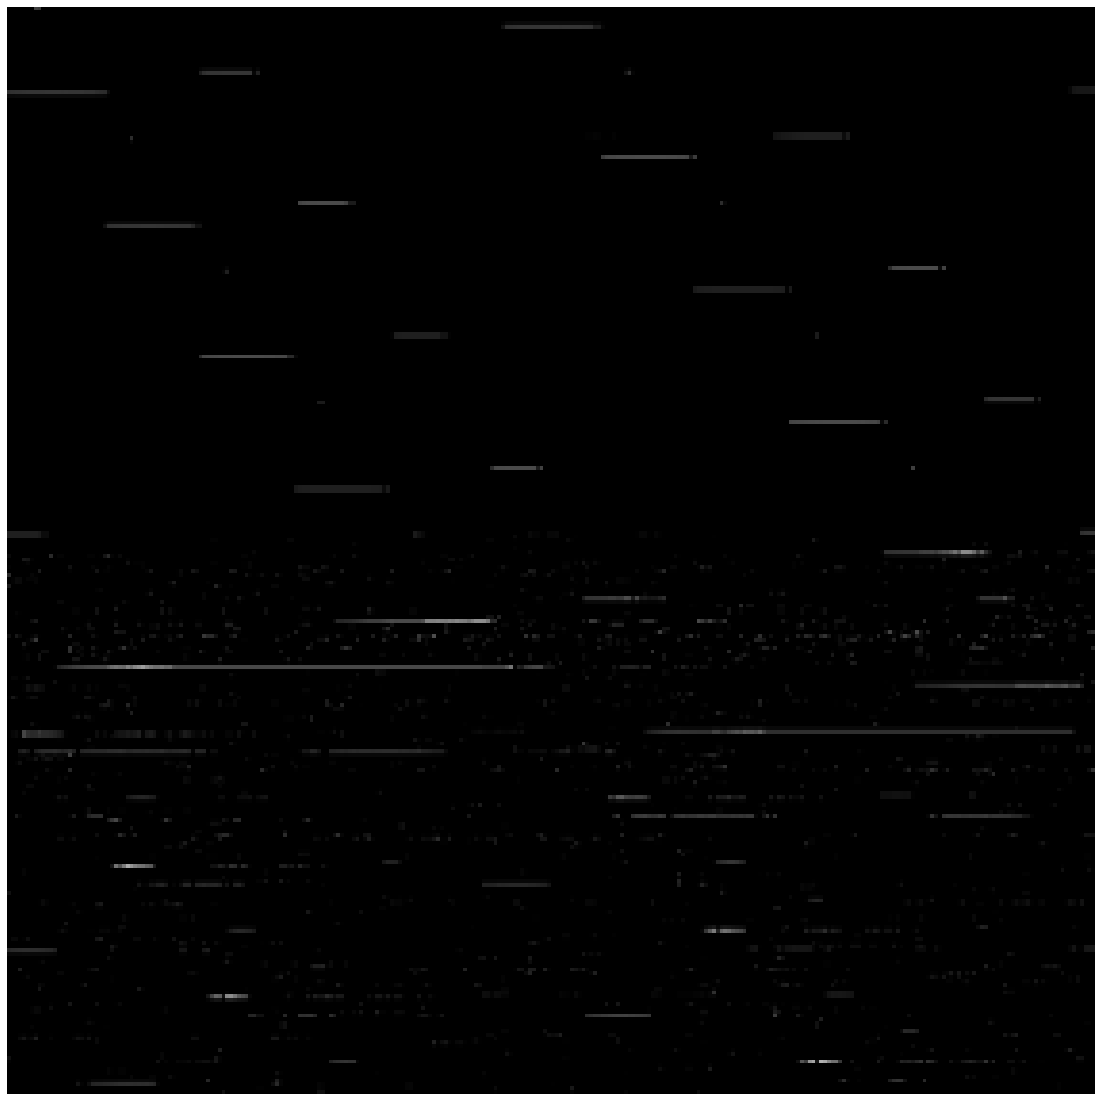

In [20]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_audio_dicts(ds_val)
for d in random.sample(dataset_dicts, 2):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    print(outputs["instances"])
    v = Visualizer(im[:, :, ::-1],
                   metadata=audio_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(20,20))
    plt.imshow(v.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()

In [ ]:
Another small thing to remember: detectron2 models do not support model.to(device) or model.cpu(). The device is defined in cfg.MODEL.DEVICE and cannot be changed afterwards.